# Detailed Explanation of the Option Pricing Code Using the COS Method and Bates Implied Vol

This notebook explains each function in the code, including all formulas in LaTeX and explanations in two blocks:
1. **Quant Finance Connection:** How the concept is used in practice.
2. **Nitish Sir Hinglish Explanation:** A simplified, colloquial explanation.

---















## 1. `CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)`

### What It Does
This function prices European call/put options using the **COS method** (Fourier cosine expansion). It uses the characteristic function `cf` of the underlying asset’s log-price process to compute the option’s price.

### Main Formula
The COS method approximates the option price as:
$$
V \approx e^{-r\tau} \, K \sum_{k=0}^{N-1} \operatorname{Re}\left\{ e^{i\,u_k\,(x_0-a)}\, \phi(u_k)\, H_k \right\},
$$
where:
- \( x_0 = \ln\left(\frac{S_0}{K}\right) \) (log-moneyness)
- \( u_k = \dfrac{k\pi}{b-a} \) for \( k = 0, 1, \dots, N-1 \)
- The truncation domain is defined as:
  $$
  a = -L\sqrt{\tau} \quad \text{and} \quad b = L\sqrt{\tau}
  $$
- \( \phi(u_k) \) is the characteristic function evaluated at \( u_k \).
- \( H_k \) are the Fourier cosine coefficients (computed in another function).

**Note:** The \( k=0 \) term is weighted by \( 0.5 \).

### Parameter Explanations
- **cf:** The characteristic function \( \phi(u) \) of the log-returns.
- **CP:** The option type indicator (Call or Put) from an enum.
- **S0:** The initial stock price.
- **r:** The risk-free interest rate.
- **tau:** Time to maturity (in years).
- **K:** List or array of strike prices.
- **N:** Number of expansion terms.
- **L:** Size of the truncation domain.

#### Quant Finance Connection
The COS method is highly efficient and accurate, especially for models like Heston or Bates where the characteristic function is known. It is widely used for fast option pricing and model calibration.

#### Nitish Sir Hinglish Explanation
"Arre bhai, yeh function option ka price nikalne ke liye COS method ka use karta hai. Matlab, hum log option ko Fourier cosine series se approximate karte hain. S0, K, r, tau yeh sab basic inputs hain, aur L se hum integration ka range set karte hain. Isse price bahut tezi se calculate ho jati hai!"

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import enum 
import scipy.optimize as optimize
import seaborn as sns


# set i= imaginary number
i   = 1j

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    if K is not np.array:
        K=np.array(K).reshape([len(K),1])
        
    i=1j
    x0=np.log(S0/K)
    a=0.0-L*np.sqrt(tau) 
    b=0.0+L*np.sqrt(tau)
    # sumation frm k=0 to k=n-1
    k=np.linspace(0, N-1,N).reshape([N, 1])
    u=k*np.pi/(b-a)
    
    
    #cofficent hk
    H_K= CallPutCoefficients(CP,a,b,k)
    mat=np.exp(i*np.outer((x0-a), u))
    temp=cf(u)*H_K
    temp[0]=0.5*temp[0]
    value=np.exp(-r*tau)*K*np.real(mat.dot(temp))
    return value
                    

       











## 2. `CallPutCoefficients(CP, a, b, k)`

### What It Does
This function calculates the Fourier cosine coefficients \( H_k \) needed to expand the option payoff function. The computation differs between calls and puts.

### Coefficient Formulas
- **For a Call Option:**
  - Set \( c = 0 \) and \( d = b \), then:
    $$
    H_k = \frac{2}{b-a} \left( \chi_k - \psi_k \right)
    $$
- **For a Put Option:**
  - Set \( c = a \) and \( d = 0 \), then:
    $$
    H_k = \frac{2}{b-a} \left( \psi_k - \chi_k \right)
    $$
  
Here, \( \chi_k \) and \( \psi_k \) are computed in the `Chi_Psi` function.

### Parameter Explanations
- **CP:** Option type (Call or Put).
- **a, b:** Lower and upper limits of the truncation domain.
- **k:** A vector of indices \( k = 0, 1, \dots, N-1 \).

#### Quant Finance Connection
Accurate Fourier coefficients are essential to convert the pricing integral into a rapidly converging series, making the method very efficient in practice.

#### Nitish Sir Hinglish Explanation
"Yeh function Fourier coefficients nikalta hai jo option ke payoff ko series mein likhne ke liye zaroori hote hain. Call ke liye hum Chi minus Psi, aur put ke liye Psi minus Chi karte hain. Isse series ban jaati hai jisse price calculate karna efficient ho jata hai!"

---


In [4]:
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:
        c=0.0
        d=b
        coef=Chi_Psi(a,b,c,d,k)
        Chi_k=coef["chi"]
        Psi_k=coef["psi"]
        if a<b and b<0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k  

## 3. `Chi_Psi(a, b, c, d, k)`

### What It Does
This function computes the two integrals, \( \chi_k \) and \( \psi_k \), which are the building blocks for the Fourier cosine coefficients used in the COS method.

### The Formulas

#### For \(\psi_k\):
- **When \( k = 0 \):**
  $$
  \psi_0 = d - c
  $$
- **For \( k > 0 \):**
  $$
  \psi_k = \frac{b-a}{k\pi}\left[\sin\left(\frac{k\pi(d-a)}{b-a}\right) - \sin\left(\frac{k\pi(c-a)}{b-a}\right)\right]
  $$

#### For \(\chi_k\):
Start with:
$$
\chi_k = \frac{1}{1+\left(\frac{k\pi}{b-a}\right)^2}
$$
Then, update with:
$$
\chi_k = \chi_k \times \left[ \cos\left(\frac{k\pi(d-a)}{b-a}\right)e^d - \cos\left(\frac{k\pi(c-a)}{b-a}\right)e^c + \frac{k\pi}{b-a}\left(\sin\left(\frac{k\pi(d-a)}{b-a}\right) - \sin\left(\frac{k\pi(c-a)}{b-a}\right)e^c \right) \right]
$$

### Parameter Explanations
- **a, b:** Integration limits from the COS method.
- **c, d:** Specific limits for the payoff function (different for calls and puts).
- **k:** The index vector for the Fourier series.

#### Quant Finance Connection
These integrals allow us to derive closed-form expressions for the payoff expansion, transforming a potentially slow numerical integration into a fast series summation.

#### Nitish Sir Hinglish Explanation
"Yeh function do cheezein nikalta hai—Chi aur Psi—jo option payoff ko series mein express karne ke liye zaroori hain. In formulas se hum integrate karke exact coefficients nikal lete hain, jo phir price calculate karne mein use hote hain."

---

In [5]:
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value     

## 4. `BS_Call_Option_Price(CP, S_0, K, sigma, tau, r)`

### What It Does
This function computes the Black–Scholes price for a European call or put option, a cornerstone of option pricing theory.

### The Black–Scholes Formulas

For a **Call Option**:
1. Compute:
   $$
   d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)\tau}{\sigma\sqrt{\tau}}, \quad d_2 = d_1 - \sigma\sqrt{\tau}
   $$
2. The call price is:
   $$
   C = S_0 \,\Phi(d_1) - K\, e^{-r\tau}\,\Phi(d_2)
   $$

For a **Put Option**:
$$
P = K\, e^{-r\tau}\,\Phi(-d_2) - S_0 \,\Phi(-d_1)
$$
where \( \Phi(\cdot) \) is the cumulative distribution function of the standard normal distribution.

### Parameter Explanations
- **CP:** Option type (Call or Put).
- **S_0:** Current price of the underlying asset.
- **K:** Strike price(s).
- **sigma:** Volatility of the asset’s returns.
- **tau:** Time to maturity.
- **r:** Risk-free interest rate.

#### Quant Finance Connection
The Black–Scholes model is used not only for pricing but also to compute **implied volatility**, which is key in understanding market sentiment and for model calibration.

#### Nitish Sir Hinglish Explanation
"Yeh function Black–Scholes formula se option ka price calculate karta hai. Sabse pehle \(d_1\) aur \(d_2\) nikalte hain, phir normal distribution ke CDF se price aata hai. Yeh basic model hai jo aksar interview mein poocha jata hai!"

---

In [6]:
def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(-d2) * K * np.exp(-r * tau) - stats.norm.cdf(-d1)*S_0
    return value

## 5. `ImpliedVolatility(CP, marketPrice, K, T, S_0, r)`

### What It Does
This function finds the **implied volatility** for which the Black–Scholes price equals the observed market (or computed) price.

### The Approach
1. **Initial Guess:**  
   A grid of volatility values is created (e.g., from 0 to 2), and corresponding Black–Scholes prices are computed. The initial guess for \( \sigma \) is obtained by interpolation.
   
2. **Refinement Using Newton’s Method:**  
   The function refines the initial guess by solving:
   $$
   f(\sigma) = \text{BS\_Call\_Option\_Price}(CP,S_0,K,\sigma,T,r) - \text{marketPrice} = 0
   $$
   using Newton’s method.

### Parameter Explanations
- **CP:** Option type (Call or Put).
- **marketPrice:** The target option price (from the COS method).
- **K:** Strike price.
- **T:** Time to maturity.
- **S_0:** Current asset price.
- **r:** Risk-free interest rate.

#### Quant Finance Connection
Implied volatility is crucial in options trading and risk management. Extracting it from market prices helps gauge market expectations for future volatility.

#### Nitish Sir Hinglish Explanation
"Yeh function market price ke hisaab se volatility nikalta hai. Pehle ek sigma grid se initial guess leta hai, phir Newton method se us guess ko refine karta hai taki Black–Scholes ka price market price ke barabar ho jaye."

---

In [7]:
def ImpliedVolatility(CP,marketPrice,K,T,S_0,r):
    # to difne intail volailty er ainterplooalte define a grid for sigma
    sigmaGrid=np.linspace(0, 2,200)
    optPriceGrid=BS_Call_Option_Price(CP, S_0, K, sigmaGrid, T, r)
    sigmaInitial= np.interp(marketPrice, optPriceGrid, sigmaGrid)
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # use determine input for the local search fine tuning
    func = lambda sigma: np.power(BS_Call_Option_Price(CP, S_0, K, sigma, T, r)-marketPrice,1.0)
    impliedVol= optimize.newton(func,sigmaInitial,tol=1e-10)
    print("Final volatility = {0}".format(impliedVol))
    return impliedVol

## 6. `ChFBatesModel(r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJ)`

### What It Does
This function returns the characteristic function \( \phi(u) \) for the **Bates model**, which extends the Heston model by including jumps in asset prices.

### The Formulas

1. **Define \( D_1(u) \):**
   $$
   D_1(u) = \sqrt{\left(\kappa - \gamma \rho\,i\,u\right)^2 + \gamma^2\left(u^2 + i\,u\right)}
   $$

2. **Define \( g(u) \):**
   $$
   g(u) = \frac{\kappa - \gamma \rho\,i\,u - D_1(u)}{\kappa - \gamma \rho\,i\,u + D_1(u)}
   $$

3. **Compute \( C(u) \):**
   $$
   C(u) = \frac{1 - e^{-D_1(u)\tau}}{\gamma^2 \left(1 - g(u)e^{-D_1(u)\tau}\right)}\left(\kappa - \gamma \rho\,i\,u - D_1(u)\right)
   $$

4. **Heston Component \( A_{\text{Hes}}(u) \):**
   $$
   A_{\text{Hes}}(u) = r\,i\,u\,\tau + \frac{\kappa\,v_{\text{bar}}\,\tau}{\gamma^2}\left(\kappa - \gamma \rho\,i\,u - D_1(u)\right) - \frac{2\,\kappa\,v_{\text{bar}}}{\gamma^2}\ln\left(\frac{1 - g(u)e^{-D_1(u)\tau}}{1 - g(u)}\right)
   $$

5. **Include Jump Components:**
   $$
   A(u) = A_{\text{Hes}}(u) - \xi_P\,i\,u\,\tau\left(e^{\mu_J + \frac{1}{2}\sigma_J^2} - 1\right) + \xi_P\,\tau\left(e^{i\,u\,\mu_J - \frac{1}{2}\sigma_J^2\,u^2} - 1\right)
   $$

6. **Final Characteristic Function:**
   $$
   \phi(u) = \exp\Big( A(u) + C(u)\,v_0 \Big)
   $$

### Parameter Explanations
- **r:** Risk-free interest rate.
- **tau:** Time to maturity.
- **kappa:** Mean-reversion speed of the variance process.
- **gamma:** Volatility of the volatility (vol-of-vol).
- **vbar:** Long-run average variance.
- **v0:** Initial variance.
- **rho:** Correlation between asset price and variance.
- **xiP:** Jump intensity (frequency of jumps).
- **muJ:** Mean jump size (in log-returns).
- **sigmaJ:** Standard deviation of the jump size.

#### Quant Finance Connection
The Bates model captures both the continuous stochastic volatility and the sudden, discontinuous jumps observed in asset prices. It is useful for pricing options with pronounced volatility smiles or skews.

#### Nitish Sir Hinglish Explanation
"Is function mein hum Bates model ka characteristic function calculate karte hain. Bates model mein hum volatility ko stochastic rakhte hain aur saath hi jumps (sudden price moves) bhi add karte hain. Matlab, market ke unpredictable moves ko bhi capture kar sakte hain!"

---

In [8]:
def ChFBatesModel(r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJ):
    i = 1j
    D1 = lambda u: np.sqrt(np.power(kappa - gamma * rho * i * u, 2) + (u * u + i * u) * gamma * gamma)
    g = lambda u: (kappa - gamma * rho * i * u - D1(u)) / (kappa - gamma * rho * i * u + D1(u))
    C = lambda u: (1.0 - np.exp(-D1(u) * tau)) / (gamma * gamma * (1.0 - g(u) * \
                                                                   np.exp(-D1(u) * tau))) * (
                              kappa - gamma * rho * i * u - D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    AHes = lambda u: r * i * u * tau + kappa * vbar * tau / gamma / gamma * (kappa - gamma * \
                                                                             rho * i * u - D1(
                u)) - 2 * kappa * vbar / gamma / gamma * np.log((1.0 - g(u) * np.exp(-D1(u) * tau)) / (1.0 - g(u)))

    A = lambda u: AHes(u) - xiP * i * u * tau * (np.exp(muJ + 0.5 * sigmaJ * sigmaJ) - 1.0) + \
                  xiP * tau * (np.exp(i * u * muJ - 0.5 * sigmaJ * sigmaJ * u * u) - 1.0)

    # Characteristic function for the Heston's model    
    cf = lambda u: np.exp(A(u) + C(u) * v0)
    return cf
    

# Set seaborn style for better aesthetics

In [9]:

sns.set_style("whitegrid")

def plot_implied_volatility(K, param_values, param_name, title, color_palette, r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJ, CP, S0, N, L):
    """
    Function to plot the effect of a parameter on implied volatility.
    
    Parameters:
    - K: Strike prices
    - param_values: List of values for the parameter being varied
    - param_name: The name of the parameter (str)
    - title: Title of the plot (str)
    - color_palette: Seaborn color palette (str)
    - Other model parameters required for computation
    """
    plt.figure(figsize=(8, 5))
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Strike, K", fontsize=12)
    plt.ylabel("Implied Volatility (%)", fontsize=12)

    legend = []
    colors = sns.color_palette(color_palette, len(param_values))

    for i, param_value in enumerate(param_values):
        # Assign varying parameter to the model
        cf = ChFBatesModel(
            r, tau, kappa, gamma, vbar, v0, rho,
            param_value if param_name == 'xiP' else xiP,
            param_value if param_name == 'muJ' else muJ,
            param_value if param_name == 'sigmaJ' else sigmaJ
        )

        # Compute option prices
        valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

        # Calculate implied volatilities
        IV = np.array([ImpliedVolatility(CP, valCOS[idx], K[idx], tau, S0, r) for idx in range(len(K))])

        # Plot with unique color and markers
        plt.plot(K, IV * 100.0, linestyle='--', marker='o', markersize=4, color=colors[i], label=f"{param_name}={param_value}")

    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## 7. `mainCalculation()`

### What It Does
This is the main driver function that sets up parameters, runs experiments, and plots the results to study the effects of varying Bates model parameters on the implied volatility smile.

### Process Overview
1. **Parameter Setup:**
   - Basic option parameters: \( S_0 = 100 \), \( r = 0 \), \( \tau = 1 \) year.
   - A range of strike prices \( K \) (from 40 to 180).
   - COS method parameters: \( N = 1000 \) and \( L = 6 \).
   - Bates model parameters: \( \kappa, \gamma, v_{\text{bar}}, v_0, \rho, \xi_P, \mu_J, \sigma_J \).

2. **Experiments:**
   - **Varying Jump Intensity (\( \xi_P \)):** For different values of \( \xi_P \), compute option prices using the COS method and extract implied volatilities.
   - **Varying Mean Jump Size (\( \mu_J \)) and Jump Volatility (\( \sigma_J \)):** Similar experiments to observe their effect on the volatility smile.

3. **Plotting:**  
   The computed implied volatilities for various strikes are plotted to visualize the volatility smile.

#### Quant Finance Connection
Understanding the sensitivity of the volatility smile to jump parameters is key in model calibration. This practice is common in industry to ensure accurate option pricing and effective risk management.

#### Nitish Sir Hinglish Explanation
"Yeh function pure experiment ko run karta hai. Pehle basic parameters set kiye jaate hain, phir alag-alag jump parameters (jaise \( \xi_P \), \( \mu_J \), \( \sigma_J \)) ko vary karke dekha jata hai ki implied volatility smile par kya effect padta hai. Plot dekh ke samajh aata hai ki market me option prices ka behaviour kaise change hota hai jab jumps ka effect badhta ya kam hota hai!"

---

# Additional Interview Tips for Quants

- **Understand the COS Method:**  
  Be ready to explain how the Fourier cosine expansion converts the pricing integral into a fast-converging series.

- **Know the Model Parameters:**  
  Understand each parameter in models like Bates (e.g., \( \kappa, \gamma, \xi_P \)) and how they affect option prices and volatility smiles.

- **Practice Simplifying Complex Ideas:**  
  Explaining these concepts in simple terms (like the Nitish Sir Hinglish style) can help in interviews.

- **Hands-On Coding:**  
  Gain experience building, testing, and calibrating these models with historical or simulated data.

- **Industry Practice:**  
  These techniques are used for pricing exotic options and managing risk. Being familiar with them gives you a competitive edge in quant interviews.

---

*Happy coding and best of luck with your quant interview!*

In [10]:
def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100.0
    r   = 0.0
    tau = 1.0
    
    K = np.linspace(40,180,10)
    K = np.array(K).reshape([len(K),1])
    
    N = 1000
    L = 6
    kappa = 1.2
    gamma = 0.05
    vbar  = 0.05
    rho   = -0.75
    v0    = vbar
    muJ   = 0.0
    sigmaJ= 0.2
    xiP   = 0.1
    
    
   # Call the plotting function for each parameter variation
    plot_implied_volatility(K, [0.01, 0.1, 0.2, 0.3], 'xiP', "Effect of ξP on Implied Volatility", "coolwarm", r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJ, CP, S0, N, L)
    plot_implied_volatility(K, [-0.5, -0.25, 0, 0.25], 'muJ', "Effect of μJ on Implied Volatility", "viridis", r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJ, CP, S0, N, L)
    plot_implied_volatility(K, [0.01, 0.15, 0.2, 0.25], 'sigmaJ', "Effect of σJ on Implied Volatility", "magma", r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJ, CP, S0, N, L)
    

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16424\1910952926.py:4: RuntimeWarning: divide by zero encountered in divide
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))


Initial volatility = [0.25040538]
Final volatility = [0.25059091]
Initial volatility = [0.24041659]
Final volatility = [0.24050395]
Initial volatility = [0.23321919]
Final volatility = [0.2332936]
Initial volatility = [0.22754485]
Final volatility = [0.22756462]
Initial volatility = [0.22280138]
Final volatility = [0.22280128]
Initial volatility = [0.21873632]
Final volatility = [0.21875958]
Initial volatility = [0.21522431]
Final volatility = [0.21532504]
Initial volatility = [0.21238324]
Final volatility = [0.21247909]
Initial volatility = [0.21021393]
Final volatility = [0.21031315]
Initial volatility = [0.20875231]
Final volatility = [0.20907436]
Initial volatility = [0.26570325]
Final volatility = [0.26626029]
Initial volatility = [0.25016176]
Final volatility = [0.2502666]
Initial volatility = [0.24067142]
Final volatility = [0.24069274]
Initial volatility = [0.23427491]
Final volatility = [0.23429125]
Initial volatility = [0.22979074]
Final volatility = [0.22979065]
Initial vola

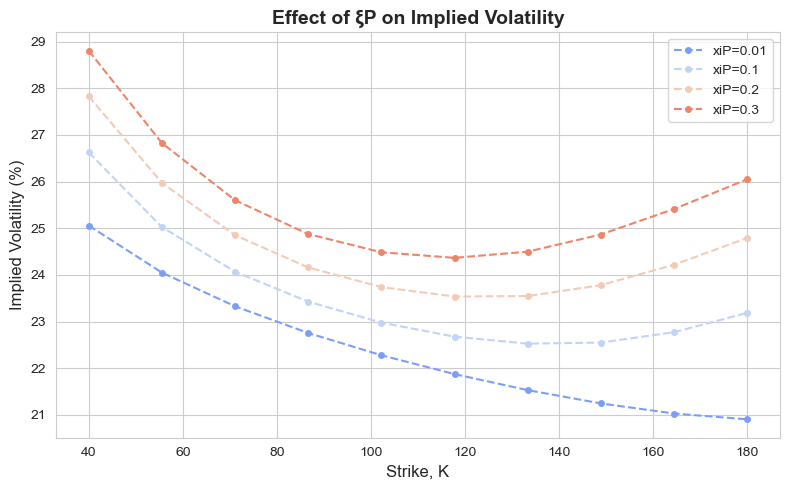

Initial volatility = [0.38194029]
Final volatility = [0.38194265]
Initial volatility = [0.34115364]
Final volatility = [0.34117635]
Initial volatility = [0.30121783]
Final volatility = [0.30122385]
Initial volatility = [0.27163136]
Final volatility = [0.2716326]
Initial volatility = [0.25311666]
Final volatility = [0.2531164]
Initial volatility = [0.24124134]
Final volatility = [0.24124165]
Initial volatility = [0.23288865]
Final volatility = [0.23293477]
Initial volatility = [0.22647636]
Final volatility = [0.22664678]
Initial volatility = [0.22155314]
Final volatility = [0.22160318]
Initial volatility = [0.2169861]
Final volatility = [0.21739082]
Initial volatility = [0.31458899]
Final volatility = [0.31488053]
Initial volatility = [0.2835516]
Final volatility = [0.28368038]
Initial volatility = [0.26061472]
Final volatility = [0.26063608]
Initial volatility = [0.24584837]
Final volatility = [0.24586485]
Initial volatility = [0.23616207]
Final volatility = [0.23616179]
Initial volati

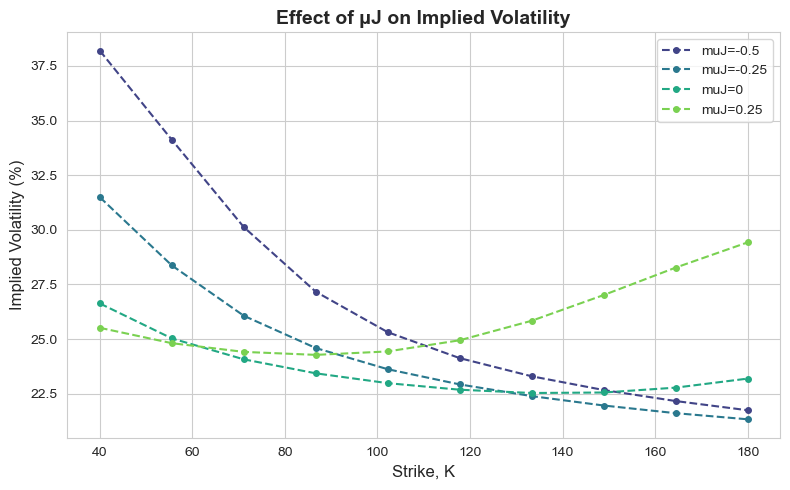

Initial volatility = [0.24756333]
Final volatility = [0.24817878]
Initial volatility = [0.23913236]
Final volatility = [0.23933503]
Initial volatility = [0.23241703]
Final volatility = [0.23246751]
Initial volatility = [0.22680842]
Final volatility = [0.2268296]
Initial volatility = [0.22203914]
Final volatility = [0.22203909]
Initial volatility = [0.21784437]
Final volatility = [0.21787283]
Initial volatility = [0.21409998]
Final volatility = [0.21418863]
Initial volatility = [0.21087511]
Final volatility = [0.21088994]
Initial volatility = [0.20759928]
Final volatility = [0.20790802]
Initial volatility = [0.20471297]
Final volatility = [0.20519203]
Initial volatility = [0.2551264]
Final volatility = [0.25574009]
Initial volatility = [0.24449249]
Final volatility = [0.24475706]
Initial volatility = [0.23696734]
Final volatility = [0.23707437]
Initial volatility = [0.23123841]
Final volatility = [0.23123905]
Initial volatility = [0.22664385]
Final volatility = [0.22664367]
Initial vola

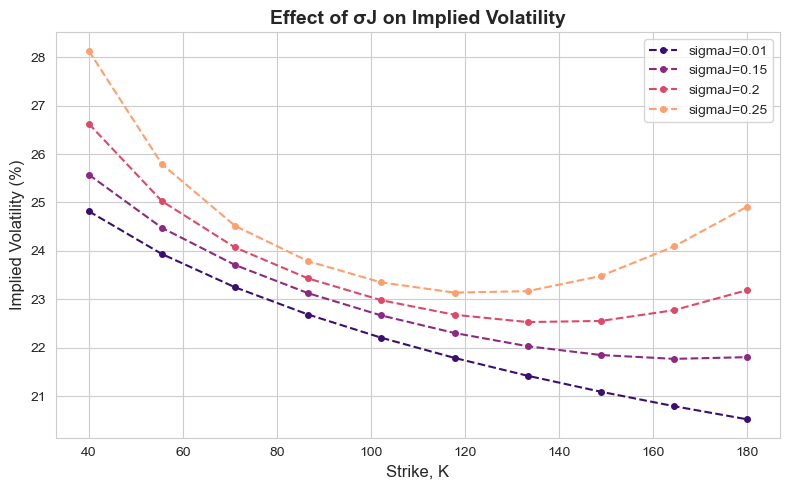

In [11]:
mainCalculation()

 """ # effect of xiP
    plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    xiPV = [0.01, 0.1, 0.2, 0.3]
    legend = []
    for xiPTemp in xiPV:
        # Evaluate the Bates model
        # Compute ChF for the Bates
        cf = ChFBatesModel(r, tau, kappa, gamma, vbar, v0, rho, xiPTemp, muJ, sigmaJ)

        # The COS method
        valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

        # Implied volatilities
        IV = np.zeros([len(K), 1])
        for idx in range(0, len(K)):
            IV[idx] = ImpliedVolatility(CP, valCOS[idx], K[idx], tau, S0, r)
        plt.plot(K, IV * 100.0)
        legend.append('xiP={0}'.format(xiPTemp))
    plt.legend(legend)

    # effect of muJ
    plt.figure(2)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    muJPV = [-0.5, -0.25, 0, 0.25]
    legend = []
    for muJTemp in muJPV:
        # Evaluate the Bates model
        # Compute ChF for the Bates
        cf = ChFBatesModel(r, tau, kappa, gamma, vbar, v0, rho, xiP, muJTemp, sigmaJ)

        # The COS method
        valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

        # Implied volatilities
        IV = np.zeros([len(K), 1])
        for idx in range(0, len(K)):
            IV[idx] = ImpliedVolatility(CP, valCOS[idx], K[idx], tau, S0, r)
        plt.plot(K, IV * 100.0)
        legend.append('muJ={0}'.format(muJTemp))
    plt.legend(legend)

    # effect of sigmaJ
    plt.figure(3)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    sigmaJV = [0.01, 0.15, 0.2, 0.25]
    legend = []
    for sigmaJTemp in sigmaJV:
        # Evaluate the Bates model
        # Compute ChF for the Bates
        cf = ChFBatesModel(r, tau, kappa, gamma, vbar, v0, rho, xiP, muJ, sigmaJTemp)

        # The COS method
        valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

        # Implied volatilities
        IV = np.zeros([len(K), 1])
        for idx in range(0, len(K)):
            IV[idx] = ImpliedVolatility(CP, valCOS[idx], K[idx], tau, S0, r)
        plt.plot(K, IV * 100.0)
        legend.append('sigmaJ={0}'.format(sigmaJTemp))
    plt.legend(legend)"""